In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

## Optimizing using GD and artificial data

In [2]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [3]:
def utility_function_grad(r_p, gamma, r_p_grad):
    u_grad = np.power((1+r_p),-gamma) * r_p_grad
    return u_grad

## Optimization formula:
## $\underset{\theta}{\max} \frac{1}{T} \sum^{T-1}_{t=0} u\left( \sum_{i=1}^{N_{t}}( \bar{w}_{i,t} + \frac{1}{N_{t}}\theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} \right) $

## Critical point of formula:

## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $


## Utility function

## $u(r_{p,t+1}) = \frac{(1+r_{p,t+1})^{1-\gamma}}{1-\gamma} $

## Portfolio return
## $ r_{p,t+1} = \sum^{N_{t}}_{i=1} \bar{w}_{i,t} r_{i,t+1} + \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} $


## Utility function derivate

## $u'(r_{p,t+1}) = (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} $

## Portfolio return derivate
## $ r'_{p,t+1} = \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \hat{x}_{i,t} ) r_{i,t+1} = \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} $

## Critical point expanded:
## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} (r'_{p, t+1})^2 $

In [10]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# random initialization of theta for 3 firm characteristics
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [11]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [12]:
np.random.seed(123)
theta = np.random.rand(1, 3)
for k in tqdm(range(epochs)):
    r_p_grad=0
    r_p = 0
    # Optmize Theta over all stocks and times
#     print(f" Theta :{theta}, k:{k}")
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        # Multiply only t-1 firm characteristics
        # Starting return r at t+1
        r_p_grad += firm_df[:-1].T * r[i, 1:]
        r_p +=  w_benchmark[i,:-1]*r[i, 1:] + (1/number_of_stocks)*firms_coeff[:,:-1]*r[i, 1:]
    r_p_grad *= (1/number_of_stocks)
    u_grad = utility_function_grad(r_p, gamma, r_p_grad)
    # It will be changed with u_grad
    gradient = (r_p_grad * u_grad).T.sum()/time
#     print(f" Gradient :{gradient.to_numpy()}, k:{k}\n")
    theta += lr * gradient

    
    # Avaliate function
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = theta.dot(firm_df.T)
        w[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    
    # Using t-1 weights and r from 1 to t
    r_p = sum(w[:,:-1]*r[:,1:])
    utility_values = utility_function(5, r_p)
    # Average over T 
    average_return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(average_return_portifolio)
#     print(f"Return {average_return_portifolio}")
print(f"Finished running {epochs} epochs")


Finished running 5000 epochs


In [23]:
np.sum(w, axis=1)/time

array([0.16143, 0.16431, 0.16957, 0.15279, 0.15868, 0.04073, 0.04327,
       0.03851, 0.03118, 0.03953])

In [14]:
pd.DataFrame(return_all).describe()

,0
count,5000.000000
mean,-0.008991
std,0.000094
min,-0.009211
25%,-0.009060
50%,-0.008959
75%,-0.008906
max,-0.008897


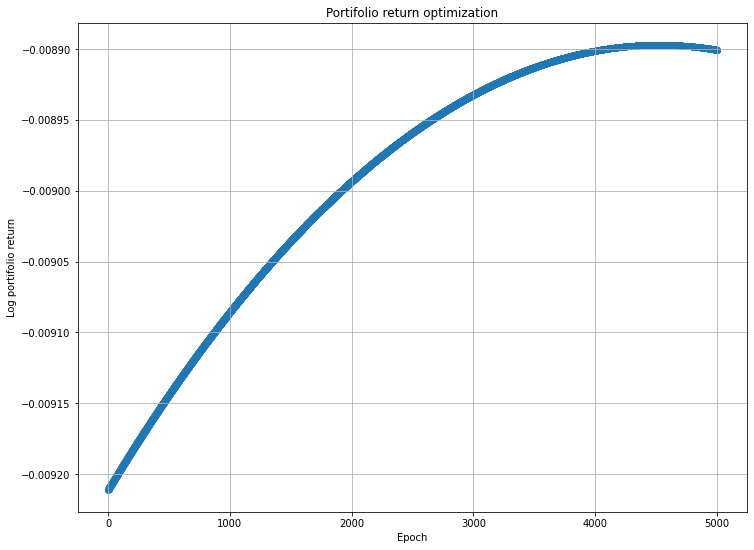

In [15]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.scatter(x=range(len(return_all)), y=return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.xlabel('Epoch')
plt.grid()
plt.show()

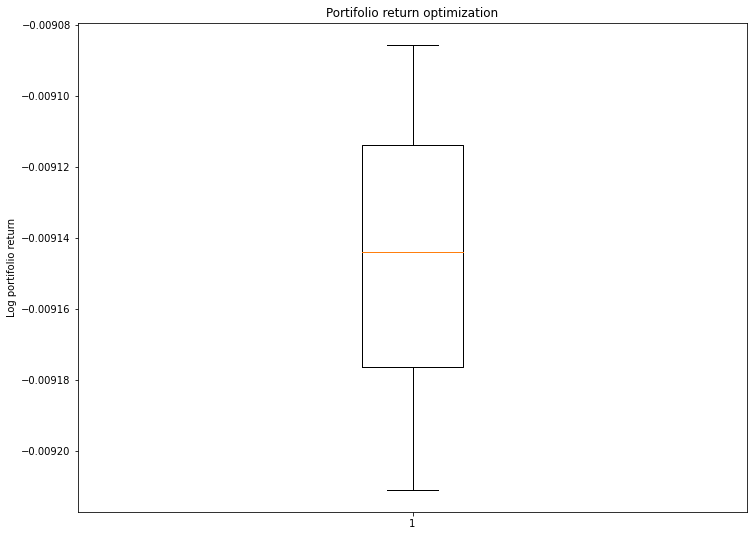

In [231]:
plt.figure(figsize=(12,9))
# plt.yscale('symlog')
plt.boxplot(return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.show()

## Using scipy to optmize easily and to add constraints

In [12]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

time = 90 # 4000 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = defaultdict(list)
# Learning rate
lr = 1e-3
epochs = 5000
return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    for t in range(time):
        # Toy firm characteristics
        if i>=5:
            # Negative return firms
            me = np.random.uniform(0,1)
            btm = np.random.uniform(-1,0)
            mom = np.random.uniform(-1,0)
        else:
            # Positive return firms
            me = np.random.uniform(-1,0)
            btm = np.random.uniform(0,1)
            mom = np.random.uniform(0,1)
#         me = np.random.uniform(-1,1)
#         btm = np.random.uniform(-1,1)
#         mom = np.random.uniform(-1,1)
            
        firm_characteristics[(i,'me')].append(me)
        firm_characteristics[(i,'btm')].append(btm)
        firm_characteristics[(i,'mom')].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")
firm_characteristics = pd.DataFrame(firm_characteristics)
# Normalize firm characteristics for each stock
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()

Created all artificial stocks


In [13]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [14]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

In [52]:
time = 90
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i] + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
    
    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [48]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69647, 0.28614, 0.22685]])

In [17]:
from scipy.optimize import minimize

In [55]:
opt_iter = 1
mean_obj_r = []
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_obj_r.append(-objective(thetaI))
    
    w_iter = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
    mean_r.append(sum(sum(w_iter*r)))
    
    opt_iter += 1

In [56]:
sol = minimize(objective, theta0, callback=callback_steps)
sol

i:1, theta i: [-0.06351 0.70841 0.74088], f(theta):1.2131658535421985
i:2, theta i: [-0.20432 0.90021 0.93178], f(theta):0.9978152325831017
i:3, theta i: [-0.52549 1.36168 1.38148], f(theta):0.6731738839743524
i:4, theta i: [-0.91579 1.94000 1.93716], f(theta):0.451484515895554
i:5, theta i: [-1.39522 2.65933 2.62362], f(theta):0.3002525460209777
i:6, theta i: [-1.98102 3.54260 3.46382], f(theta):0.1983528425988593
i:7, theta i: [-2.69483 4.62088 4.48809], f(theta):0.1301370450768914
i:8, theta i: [-3.56019 5.92892 5.72992], f(theta):0.08483774706203423
i:9, theta i: [-4.60438 7.50756 7.22839], f(theta):0.054968658415998156
i:10, theta i: [-5.85825 9.40331 9.02778], f(theta):0.03541244184901504
i:11, theta i: [-7.35715 11.66955 11.17886], f(theta):0.022691391987925764
i:12, theta i: [-9.14152 14.36743 13.73968], f(theta):0.014466088600210095
i:13, theta i: [-11.25767 17.56695 16.77670], f(theta):0.009176830512822358
i:14, theta i: [-13.75844 21.34802 20.36577], f(theta):0.0057930025887

      fun: 0.00033151769537402044
 hess_inv: array([[141944.34195, -214613.46502, -203717.71370],
       [-214613.46502, 324488.78434, 308013.86671],
       [-203717.71370, 308013.86671, 292377.30351]])
      jac: array([0.00001, -0.00000, -0.00001])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 20
     njev: 21
   status: 0
  success: True
        x: array([-40.71603, 62.10689, 59.05532])

In [20]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [28]:
np.sum(w_sol, axis=1)/time

array([8.31961, 8.38071, 8.25111, 7.94663, 8.36792, -8.06084, -7.75736,
       -8.13767, -8.13713, -8.17299])

In [44]:
sum(sum(w_benchmark*r))

190.9346282688151

In [45]:
sum(sum(w_sol*r))

22450.27196617353

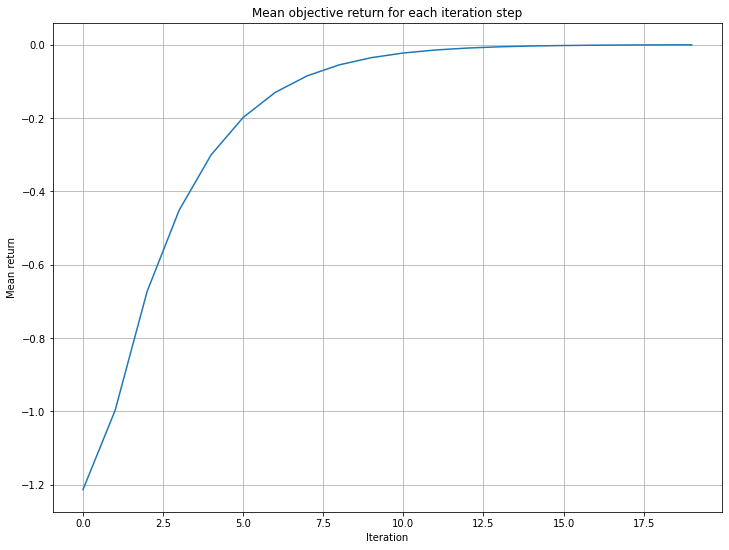

In [68]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.grid()
plt.show()

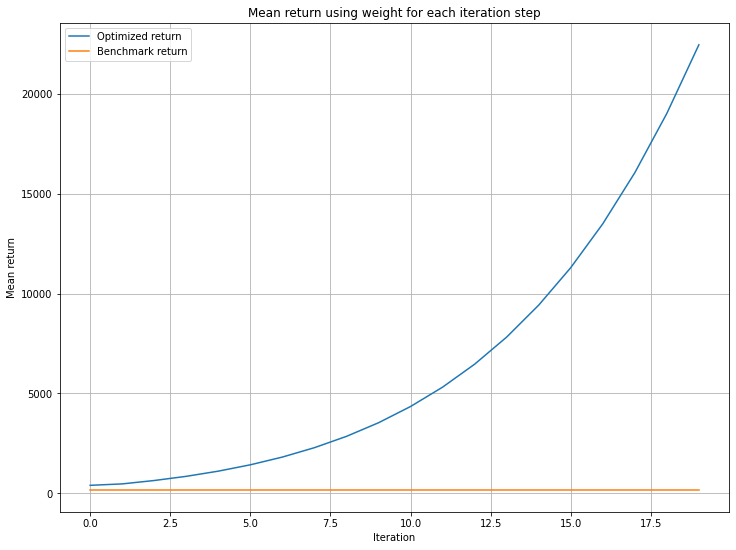

In [70]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [sum(sum(w_benchmark*r))]*len(x), label='Benchmark return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()

## Using real data

In [71]:
lreturn = pd.read_csv('lagged_return.csv')
mcap = pd.read_csv('market_cap.csv')
book_to_mkt_ratio = pd.read_csv('book_to_mkt_ratio.csv')
daily_return = pd.read_csv('daily_return.csv')

In [115]:
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)

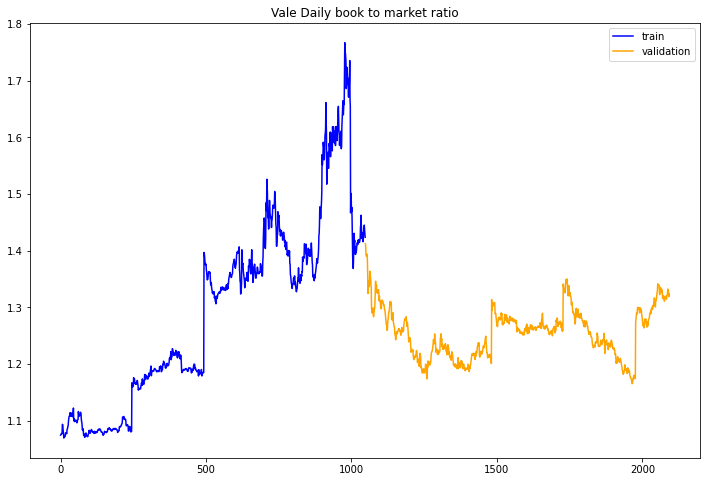

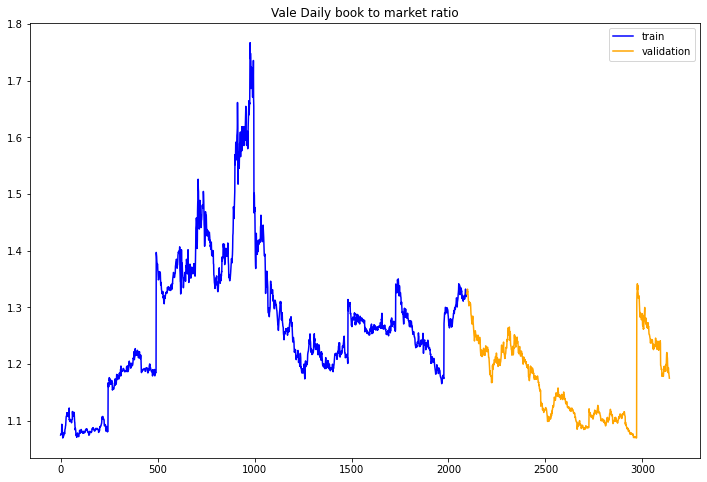

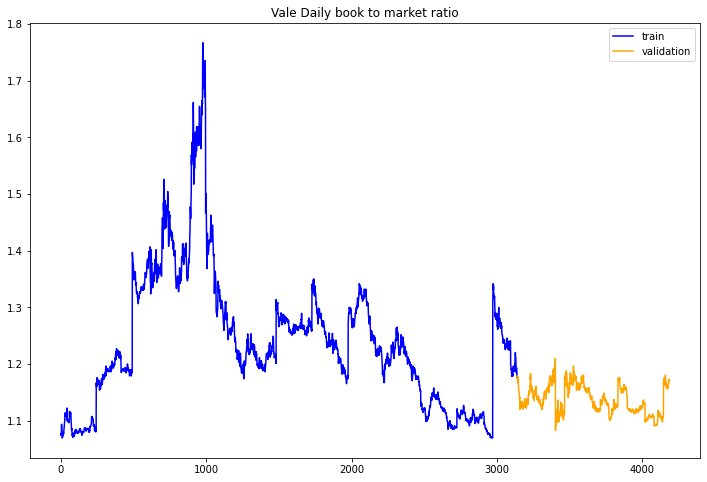

In [116]:
for train, val in splits.split(book_to_mkt_ratio):
    train_btm = book_to_mkt_ratio.loc[train]
    train_me = mcap.loc[train]
    train_mom = lreturn.loc[train]
    
    val_btm = book_to_mkt_ratio.loc[val]
    val_me = mcap.loc[val]
    val_mom = lreturn.loc[val]

    plt.figure(figsize=(12,8))
    plt.title("Vale Daily book to market ratio")
    plt.ticklabel_format(style='plain')
    train_btm['VALE3'].plot(c='blue', label='train')
    val_btm['VALE3'].plot(c='orange', label='validation')
    plt.legend()
    # plt.grid()
    plt.show()

In [102]:
firm_characteristics = defaultdict(list)

# Stocks used to test
stocks_names = ["ALPA4",
"AMBV4",
"CESP6",
"BRFS3",
"ELET6",
"VALE3",
"WEGE3",
"EMBR3",
"PETR4",
"LAME4"]

time = train_me.shape[0] 
number_of_stocks = len(stocks_names)
r = np.empty(shape=(number_of_stocks, time))
epsilon = 1e-10

for i, name in enumerate(stocks_names):
    me = train_me.get(name)
    mom = train_mom.get(name)
    btm = train_btm.get(name)
    dr = daily_return.get(name)
    
    firm_characteristics[(i,'me')] = me.fillna(method='bfill')
    firm_characteristics[(i,'btm')] = btm.fillna(method='bfill')
    firm_characteristics[(i,'mom')]= mom.fillna(method='bfill')
    
    r[i] = dr.fillna(method='bfill')[:time]

print("Created firm characteristics matrix")
firm_characteristics = pd.DataFrame(firm_characteristics)
#Normalize firm characteristics for each stock
sum_df = firm_characteristics.T.loc[(slice(None), "me"), :].sum()
firm_characteristics.T.loc[(slice(None), "me"), :] -= firm_characteristics.T.loc[(slice(None), "me"), :].mean()
firm_characteristics.T.loc[(slice(None), "me"), :] /= (sum_df + epsilon)

sum_df = firm_characteristics.T.loc[(slice(None), "btm"), :].sum()
firm_characteristics.T.loc[(slice(None), "btm"), :] -= firm_characteristics.T.loc[(slice(None), "btm"), :].mean()
firm_characteristics.T.loc[(slice(None), "btm"), :] /= (sum_df + epsilon)


sum_df = firm_characteristics.T.loc[(slice(None), "mom"), :].sum()
firm_characteristics.T.loc[(slice(None), "mom"), :] -= firm_characteristics.T.loc[(slice(None), "mom"), :].mean()
firm_characteristics.T.loc[(slice(None), "mom"), :] /= (sum_df + epsilon)

print("Normalized firm characteristics")

Created firm characteristics matrix
Normalized firm characteristics


In [103]:
firm_characteristics.describe()

0                                      1               \
                me          btm          mom           me          btm   
count  3140.000000  3140.000000  3140.000000  3140.000000  3140.000000   
mean     -0.097183    -0.035748    -0.063728     0.013855    -0.038706   
std       0.001591     0.026659    12.311070     0.033863     0.015901   
min      -0.098984    -0.074731  -555.761089    -0.059762    -0.072930   
25%      -0.098123    -0.054940    -0.100000    -0.016794    -0.049886   
50%      -0.097820    -0.041281    -0.100000     0.023894    -0.041052   
75%      -0.096634    -0.026849     0.082330     0.039578    -0.027837   
max      -0.090057     0.050113   294.982179     0.099714    -0.002972   

                              2                                      3  ...  \
               mom           me          btm          mom           me  ...   
count  3140.000000  3140.000000  3140.000000  3140.000000  3140.000000  ...   
mean      0.408491    -0.070522     0.221591    -0.161902    -0.093298  ...   
std      19.866534     0.030291     0.152425     4.955216     0.001714  ...   
min    -133.261408    -0.097359     0.013445  -269.867158    -0.096713  ...   
25%      -0.126061    -0.094910     0.083901    -0.100000    -0.094874  ...   
50%      -0.014763    -0.086871     0.189718    -0.100000    -0.093170  ...   
75%       0.139541    -0.040569     0.369621    -0.100000    -0.091889  ...   
max    1064.229454     0.007330     0.537393    36.916124    -0.089588  ...   

                 6            7                                      8  \
               mom           me          btm          mom           me   
count  3140.000000  3140.000000  3140.000000  3140.000000  3140.000000   
mean     -0.072439    -0.062389    -0.016027    -0.450855     0.278349   
std       0.628061     0.025225     0.054986    16.511398     0.088385   
min      -6.966491    -0.099011    -0.076010  -633.445258     0.066854   
25%      -0.100000    -0.087245    -0.054140    -0.100000     0.227566   
50%      -0.100000    -0.061756    -0.038007    -0.100000     0.301422   
75%      -0.100000    -0.040928     0.002415     0.139218     0.344728   
max      26.404066     0.000738     0.265781   140.977579     0.421226   

                                           9                            
               btm          mom           me          btm          mom  
count  3140.000000  3140.000000  3140.000000  3140.000000  3140.000000  
mean     -0.026162     0.193825    -0.090103    -0.034672     0.453223  
std       0.021347     9.081241     0.007071     0.023225    12.878114  
min      -0.065448  -386.558397    -0.098942    -0.089716  -175.359371  
25%      -0.044316    -0.100000    -0.095781    -0.050483    -0.116663  
50%      -0.028452     0.047580    -0.091905    -0.038802    -0.002057  
75%      -0.005834     0.216869    -0.085913    -0.021254     0.229307  
max       0.035385   215.715465    -0.065411     0.043287   576.399722  

[8 rows x 30 columns]

In [104]:
# Creating a weight from a benchmark portifolio this one
# specific is related to return of each stock for simplicity
w_benchmark = np.empty(shape=(number_of_stocks, time))
epsilon=1e-5
for t in range(time):
    positive_returns = (r[:,t]-min(r[:,t]))+epsilon
    w_benchmark[:,t] = positive_returns/sum(positive_returns)

In [10]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

3

In [89]:
def objective(theta): 
    w = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w[i] = w_benchmark[i].copy() + (1/number_of_stocks)*theta.dot(firm_characteristics[i].copy().T)
#     return w
    return -sum(sum(utility_function(5, w[:,:-1]*r[:,1:])))/time

In [76]:
def constraint(theta):
    w_sol = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        firm_df = firm_characteristics[i].copy()
        firms_coeff = sol_theta.dot(firm_df.T)
        w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff
    mean_w = np.sum(w_sol, axis=1)/time
    return mean_w

cons = [{"type" : "ineq", "fun" : constraint}]

In [77]:
np.random.seed(123)
theta0 = np.random.rand(1, 3)
theta0

array([[0.69647, 0.28614, 0.22685]])

In [78]:
from scipy.optimize import minimize, differential_evolution

In [106]:
opt_iter = 1
mean_obj_r = []
mean_r = []
def callback_steps(thetaI):
    global opt_iter
    print(f"i:{opt_iter}, theta i: {thetaI}, f(theta):{objective(thetaI)}")
    mean_obj_r.append(-objective(thetaI))
    
    w_iter = np.empty(shape=(number_of_stocks, time))
    for i in range(number_of_stocks):
        w_iter[i] = w_benchmark[i] + (1/number_of_stocks)*thetaI.dot(firm_characteristics[i].copy().T)
    mean_r.append(sum(sum(w_iter*r)))
    
    opt_iter += 1

In [107]:
# sol = minimize(objective, theta0, callback=callback_steps, method='COBYLA', constraints=cons)
sol = minimize(objective, theta0, callback=callback_steps, method='BFGS')
sol

i:1, theta i: [-0.22676 0.25280 -0.18136], f(theta):357373567.70375043
i:2, theta i: [-0.20840 0.25353 -0.22321], f(theta):3004280.395104207
i:3, theta i: [-0.20885 0.26584 -0.22319], f(theta):2850192.394848417
i:4, theta i: [-0.20982 0.29219 -0.22316], f(theta):2575724.1428066893
i:5, theta i: [-0.21202 0.35210 -0.22307], f(theta):2138378.5938452827
i:6, theta i: [-0.21561 0.44972 -0.22292], f(theta):1757752.4754445709
i:7, theta i: [-0.21633 0.46942 -0.22289], f(theta):1737101.961936354
i:8, theta i: [-0.21639 0.47090 -0.22289], f(theta):1735177.1522856245
i:9, theta i: [-0.21656 0.47521 -0.22285], f(theta):1719201.0777061763
i:10, theta i: [-0.21662 0.47592 -0.22278], f(theta):1691104.6619103383
i:11, theta i: [-0.21648 0.47073 -0.22267], f(theta):1640197.3194025334
i:12, theta i: [-0.21599 0.45478 -0.22248], f(theta):1549231.6631985465
i:13, theta i: [-0.21477 0.41605 -0.22210], f(theta):1404452.2612384276
i:14, theta i: [-0.21292 0.35863 -0.22161], f(theta):1330066.8264609796
i:15

      fun: 1104053.5517822367
 hess_inv: array([[0.00000, -0.00000, 0.00000],
       [-0.00000, 0.00000, -0.00000],
       [0.00000, -0.00000, 0.00000]])
      jac: array([1.82812, -0.17188, 20.42188])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 387
      nit: 50
     njev: 94
   status: 2
  success: False
        x: array([-0.21903, 0.37508, -0.22175])

In [108]:
sol_theta = sol.x
w_sol = np.empty(shape=(number_of_stocks, time))
for i in range(number_of_stocks):
    firm_df = firm_characteristics[i].copy()
    firms_coeff = sol_theta.dot(firm_df.T)
    w_sol[i] = w_benchmark[i] + (1/number_of_stocks)*firms_coeff

In [109]:
np.sum(w_sol, axis=1)/time

array([0.10341, 0.09105, 0.10246, 0.10040, 0.10716, 0.09843, 0.09373,
       0.11262, 0.09395, 0.09679])

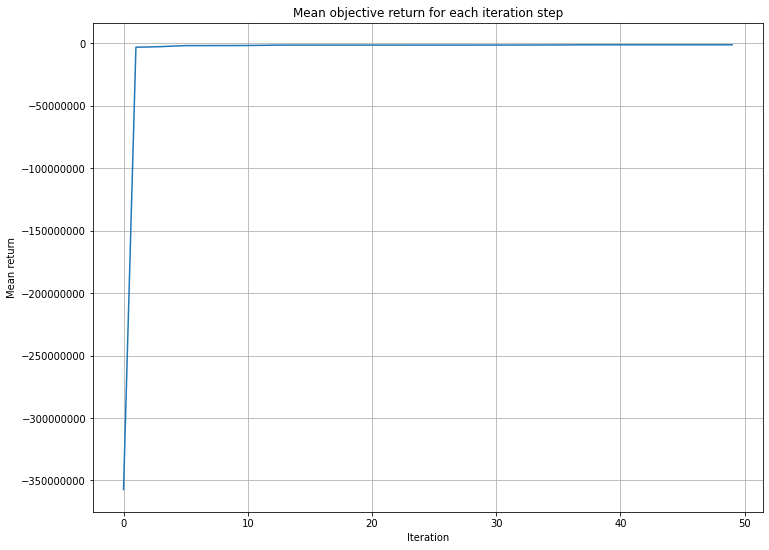

In [110]:
x = range(len(mean_obj_r))
plt.figure(figsize=(12,9))
plt.title("Mean objective return for each iteration step")
plt.plot(x, mean_obj_r)
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.ticklabel_format(style='plain')
plt.grid()
plt.show()

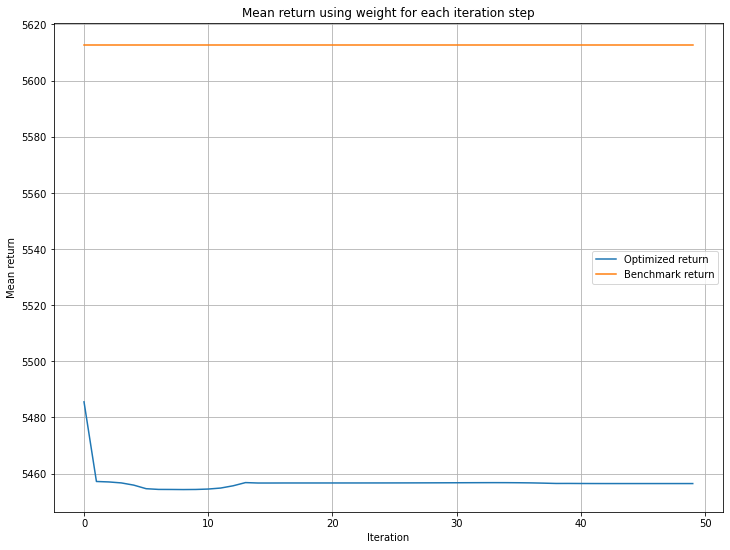

In [111]:
x = range(len(mean_r))
plt.figure(figsize=(12,9))
plt.title("Mean return using weight for each iteration step")
plt.plot(x, mean_r, label='Optimized return')
plt.plot(x, [sum(sum(w_benchmark*r))]*len(x), label='Benchmark return')
plt.xlabel('Iteration')
plt.ylabel('Mean return')
plt.legend()
plt.grid()
plt.show()